# Admixture data

In [17]:
import re, os, sys, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from ChromosomeWindows import window
# import genominterv


### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

In [3]:
window_size = 100000

### Local code in the scripts dir on the cluster

In [4]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Plotting setup

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

numpy.random.seed(7)

## Load meta data

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

In [8]:
region_colors

{'Africa': '#e41a1c',
 'WestEurasia': '#377eb8',
 'CentralAsiaSiberia': '#984ea3',
 'SouthAsia': '#4daf4a',
 'Oceania': '#ff7f00',
 'EastAsia': '#ffff33',
 'America': '#a65628'}

## Laurtis admixture data

### Without repeat regions

Laurits decodeed a few Africans by mistake, so I need to filter to get only the Africans:

In [9]:
non_african_indiv = [i for i, d in individuals.items() if d['Region'] != 'Africa' and d['Genetic sex assignment'] == 'XY']

In [10]:
min_post_prop_cutoff = 0.8

male_x_admix_segments = (pandas.read_table(str(data_dir / 'laurits_data/RestofworldHMMHaploid_samePAR.txt'), 
                                          dtype={'chrom': str})
                         .loc[lambda df: df.name.isin(non_african_indiv)]
                         .loc[lambda df: df.MeanProb >= min_post_prop_cutoff]
                        )

male_x_admix_segments.snps.fillna('', inplace=True)
male_x_admix_segments.Altai.fillna('', inplace=True)
male_x_admix_segments.Denisova.fillna('', inplace=True)
male_x_admix_segments.Vindija.fillna('', inplace=True)

male_x_admix_segments['archaic_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.snps.str.split(',')]
male_x_admix_segments['altai_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Altai.str.split(',')]
male_x_admix_segments['denisova_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Denisova.str.split(',')]
male_x_admix_segments['vindija_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Vindija.str.split(',')]

male_x_admix_segments.to_hdf(results_dir / 'male_x_admix_segments.hdf', 'df', format='table', mode='w')

print(len(male_x_admix_segments))
male_x_admix_segments.head()

1359


,name,chrom,start,end,length,state,snps,region,method,dataset,...,Altai,Denisova,Vindija,Denis,sex,LongestGap,archaic_snps,altai_snps,denisova_snps,vindija_snps
101,S_Brahui-2,X,20456000,20499000,43000,2,"20460465,20470345,20475029,20483946,20493226,2...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,1,6,0,0,0
104,S_Brahui-2,X,40151000,40236000,85000,2,"40157757,40158481,40170041,40187117,40228851,4...",SouthAsia,HMM,Sankararaman2016,...,40187117,40187117,40187117,SubAfrica,M,4,6,1,1,1
105,S_Brahui-2,X,49535000,49616000,81000,2,"49541070,49552902,49559642,49580786,49594136,4...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,5,8,0,0,0
106,S_Brahui-2,X,54940000,55102000,162000,2,"54948373,54950747,54976385,55026543,55034106,5...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,8,9,0,0,0
107,S_Brahui-2,X,56228000,56329000,101000,2,"56241959,56257196,56271367,56291516,56296488,5...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,5,6,0,0,0


In [11]:
len(set(male_x_admix_segments.name)), len(non_african_indiv)

(140, 140)

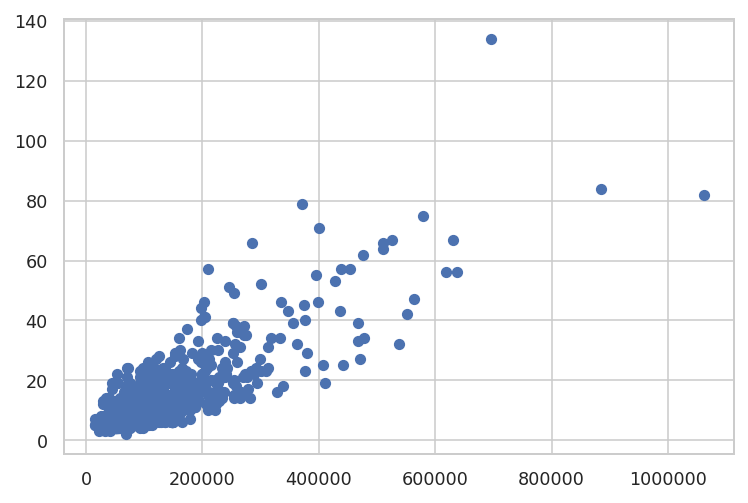

In [12]:
g = plt.scatter(male_x_admix_segments.length, male_x_admix_segments.archaic_snps)

#### Including repeat regions

In [13]:
male_x_admix_segments_full = (pandas.read_table('/project/simons/faststorage/data/HMMstuff/HMMhaploid_repeats.txt',
                                              names=['name', 'chrom', 'start', 'end', 'length',
                                                     'status', 'snps', 'population', 'country', 'region',
                                                     'MeanProb', '??', 'state', '???', 'dataset',
                                                     'method'])
                              .loc[lambda df: df.name.isin(non_african_indiv)]
                              .loc[lambda df: df.MeanProb >= min_post_prop_cutoff]
                             )
male_x_admix_segments_full.to_hdf(results_dir / 'male_x_admix_segments_full.hdf', 'df', format='table', mode='w')

print(len(male_x_admix_segments_full))
male_x_admix_segments_full.head()

1479


,name,chrom,start,end,length,status,snps,population,country,region,MeanProb,??,state,???,dataset,method
1,S_Tu-1,X,25066000,25134000,69000,Archaic,14,Tu,China,EastAsia,0.810389,0,0,0,subafr_withrepeats,HMM
2,S_Tu-1,X,43844000,43884000,41000,Archaic,12,Tu,China,EastAsia,0.873345,7,0,7,subafr_withrepeats,HMM
3,S_Tu-1,X,45081000,45118000,38000,Archaic,12,Tu,China,EastAsia,0.937195,0,2,0,subafr_withrepeats,HMM
5,S_Tu-1,X,55184000,55370000,187000,Archaic,23,Tu,China,EastAsia,0.868089,0,1,0,subafr_withrepeats,HMM
8,S_Tu-1,X,55821000,55921000,101000,Archaic,10,Tu,China,EastAsia,0.825883,1,1,1,subafr_withrepeats,HMM


In [14]:
len(set(male_x_admix_segments_full.name)), len(non_african_indiv)

(140, 140)

## Callability windows

### Analysis without repeats

In [15]:
callability_data = pandas.read_table('/home/kmt/simons/faststorage/data/1000Genomes/callabilitymask/ForHMM/Callability.bed',
                        names=['chrom', 'start', 'end', 'status'],
                        dtype={'chrom': str})
callability_data.head()

,chrom,start,end,status
0,1,756781,756870,Called
1,1,756879,756920,Called
2,1,756948,757069,Called
3,1,757071,757073,Called
4,1,757077,757246,Called


In [18]:
@window(size=window_size, fill='hg19')
def bases_analyzed(df):
    if len(df):
        return (df.end - df.start).sum()
    else:
        return 0
    
admix_callability_windows = (callability_data
             .groupby(['chrom'])
             .apply(bases_analyzed)
             .reset_index()
            )

In [19]:
admix_callability_windows.head()

,chrom,level_1,start,end,bases_analyzed
0,1,0,0,100000,0
1,1,1,100000,200000,0
2,1,2,200000,300000,0
3,1,3,300000,400000,0
4,1,4,400000,500000,0


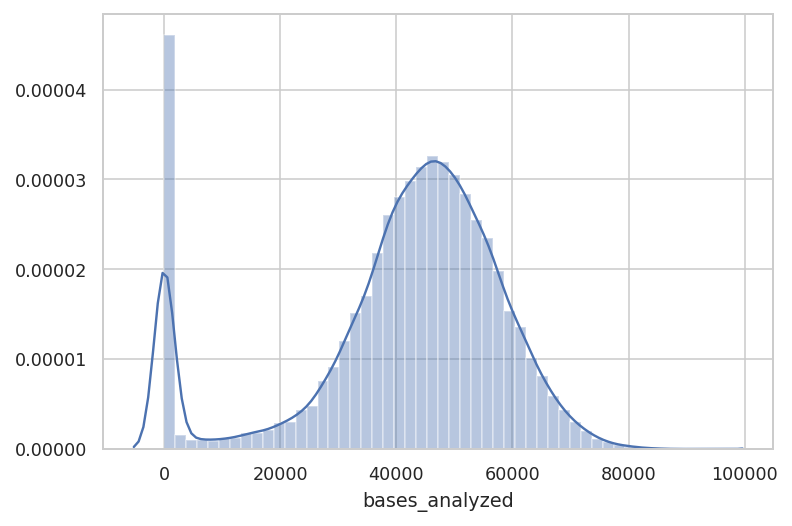

In [20]:
g = sns.distplot(admix_callability_windows.bases_analyzed)

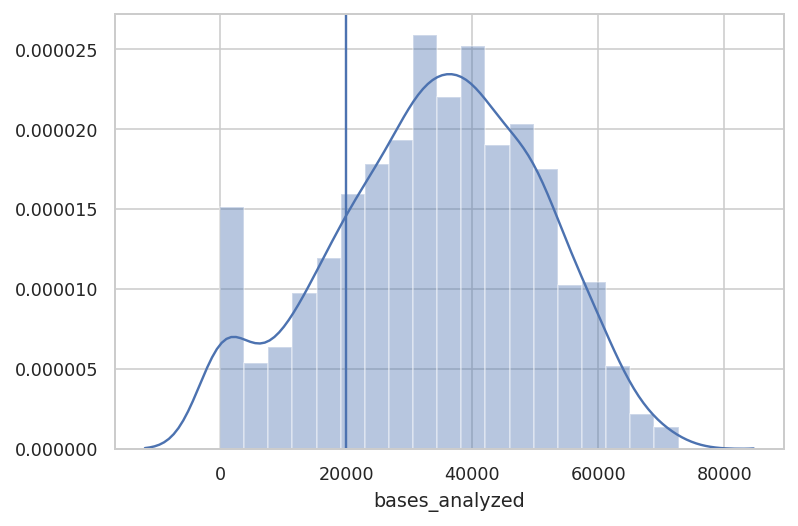

In [21]:
g = sns.distplot(admix_callability_windows.loc[lambda df: df.chrom == 'X', 'bases_analyzed'])
min_called_admix = 20000
g.axvline(20000)

### Analysis including repeats

In [22]:
callability_data_full = pandas.read_table('/project/simons/faststorage/data/HMMstuff/CallabilityFiles/weights_keeprepeats.bed',
                        names=['chrom', 'start', 'end', 'status'],
                        dtype={'chrom': str})
callability_data_full.head()

,chrom,start,end,status
0,1,754449,754462,Called
1,1,754479,754510,Called
2,1,755214,755244,Called
3,1,756781,756870,Called
4,1,756879,756920,Called


In [23]:
admix_full_callability_windows = (callability_data_full
             .groupby(['chrom'])
             .apply(bases_analyzed)
             .reset_index()
            )

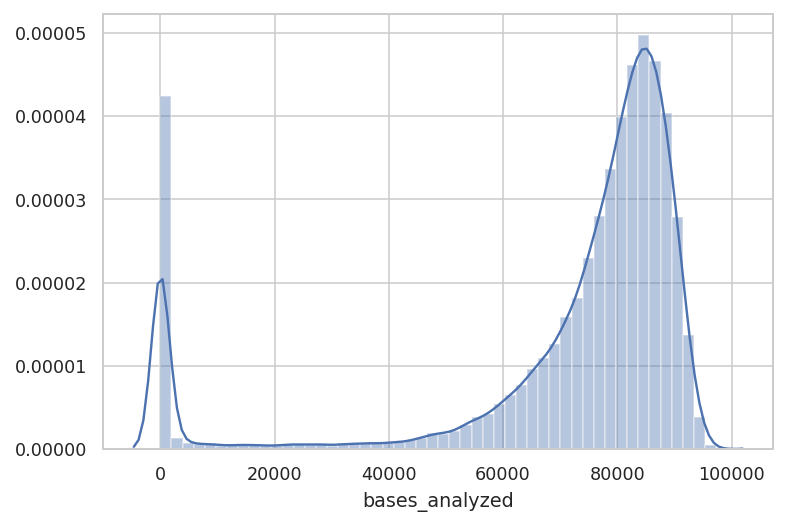

In [24]:
g = sns.distplot(admix_full_callability_windows.bases_analyzed)

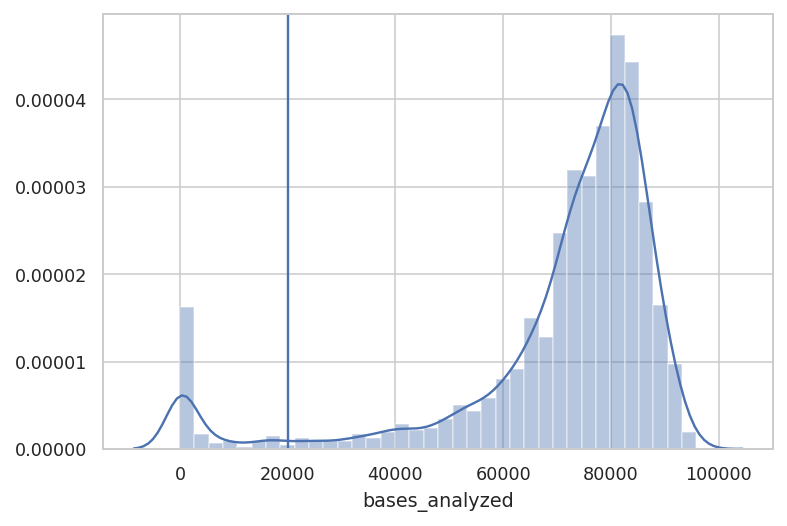

In [25]:
g = sns.distplot(admix_full_callability_windows.loc[lambda df: df.chrom == 'X', 'bases_analyzed'])
min_called_admix = 20000
g.axvline(20000)

## Segments

### Analysis without repeats

In [26]:
all_individuals = male_x_admix_segments.sort_values(['region', 'name']).name.unique()

plot_df = (male_x_admix_segments
           .assign(name = pandas.Categorical(male_x_admix_segments.name,
                                                   categories=all_individuals,
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.name.cat.codes)
          )
plot_df.head()

,name,chrom,start,end,length,state,snps,region,method,dataset,...,Denisova,Vindija,Denis,sex,LongestGap,archaic_snps,altai_snps,denisova_snps,vindija_snps,indiv_code
101,S_Brahui-2,X,20456000,20499000,43000,2,"20460465,20470345,20475029,20483946,20493226,2...",SouthAsia,HMM,Sankararaman2016,...,,,SubAfrica,M,1,6,0,0,0,67
104,S_Brahui-2,X,40151000,40236000,85000,2,"40157757,40158481,40170041,40187117,40228851,4...",SouthAsia,HMM,Sankararaman2016,...,40187117,40187117,SubAfrica,M,4,6,1,1,1,67
105,S_Brahui-2,X,49535000,49616000,81000,2,"49541070,49552902,49559642,49580786,49594136,4...",SouthAsia,HMM,Sankararaman2016,...,,,SubAfrica,M,5,8,0,0,0,67
106,S_Brahui-2,X,54940000,55102000,162000,2,"54948373,54950747,54976385,55026543,55034106,5...",SouthAsia,HMM,Sankararaman2016,...,,,SubAfrica,M,8,9,0,0,0,67
107,S_Brahui-2,X,56228000,56329000,101000,2,"56241959,56257196,56271367,56291516,56296488,5...",SouthAsia,HMM,Sankararaman2016,...,,,SubAfrica,M,5,6,0,0,0,67


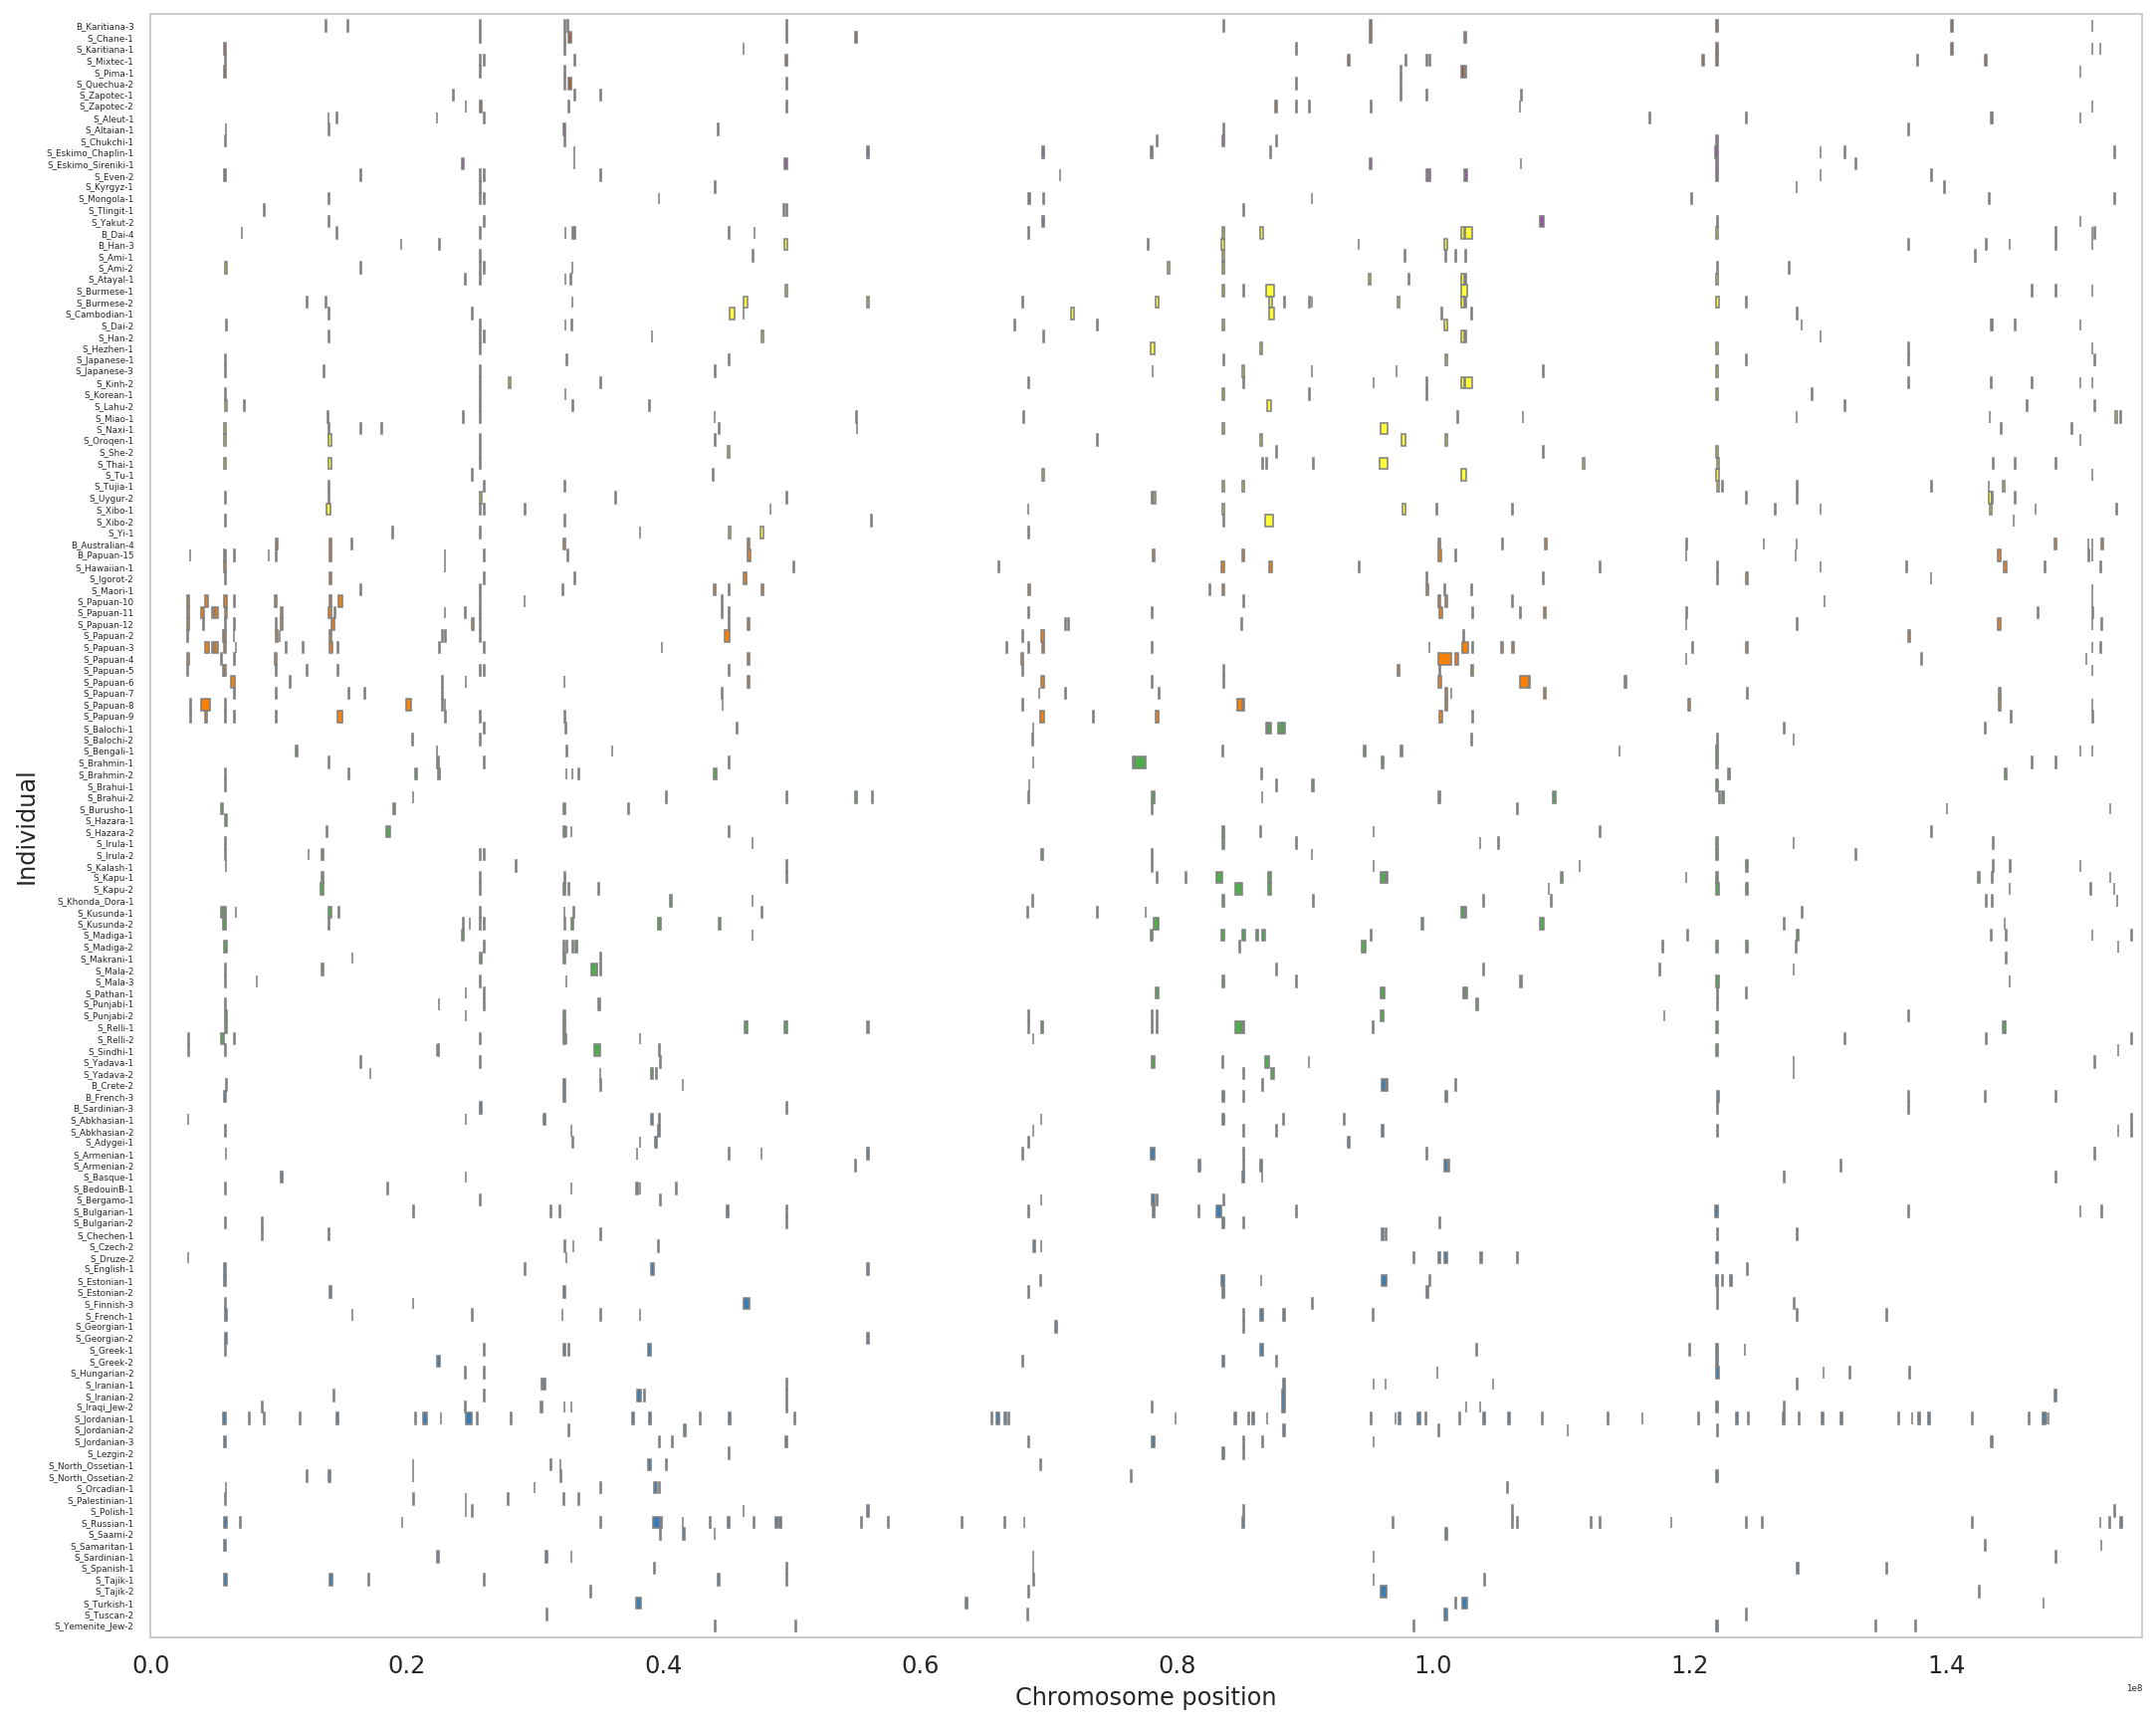

In [27]:
with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_individuals)])
        labs = pandas.Categorical(all_individuals,
                           categories=all_individuals,
                           ordered=True)
        plt.yticks(range(len(labs)), reversed(labs))

        for segm in plot_df.itertuples():            
            y = len(all_individuals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region], edgecolor='grey'))

#         for segm in callability_data.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_individuals), 
#                      facecolor='lightblue', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

#        ax.set_xlim(70e6, 90e6)
        
        plt.tight_layout()

### Analysis including repeats

In [28]:
all_individuals = male_x_admix_segments.sort_values(['region', 'name']).name.unique()

plot_df = (male_x_admix_segments_full
           .assign(name = pandas.Categorical(male_x_admix_segments_full.name,
                                                   categories=all_individuals,
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.name.cat.codes)
          )
plot_df.head()

,name,chrom,start,end,length,status,snps,population,country,region,MeanProb,??,state,???,dataset,method,indiv_code
1,S_Tu-1,X,25066000,25134000,69000,Archaic,14,Tu,China,EastAsia,0.810389,0,0,0,subafr_withrepeats,HMM,39
2,S_Tu-1,X,43844000,43884000,41000,Archaic,12,Tu,China,EastAsia,0.873345,7,0,7,subafr_withrepeats,HMM,39
3,S_Tu-1,X,45081000,45118000,38000,Archaic,12,Tu,China,EastAsia,0.937195,0,2,0,subafr_withrepeats,HMM,39
5,S_Tu-1,X,55184000,55370000,187000,Archaic,23,Tu,China,EastAsia,0.868089,0,1,0,subafr_withrepeats,HMM,39
8,S_Tu-1,X,55821000,55921000,101000,Archaic,10,Tu,China,EastAsia,0.825883,1,1,1,subafr_withrepeats,HMM,39


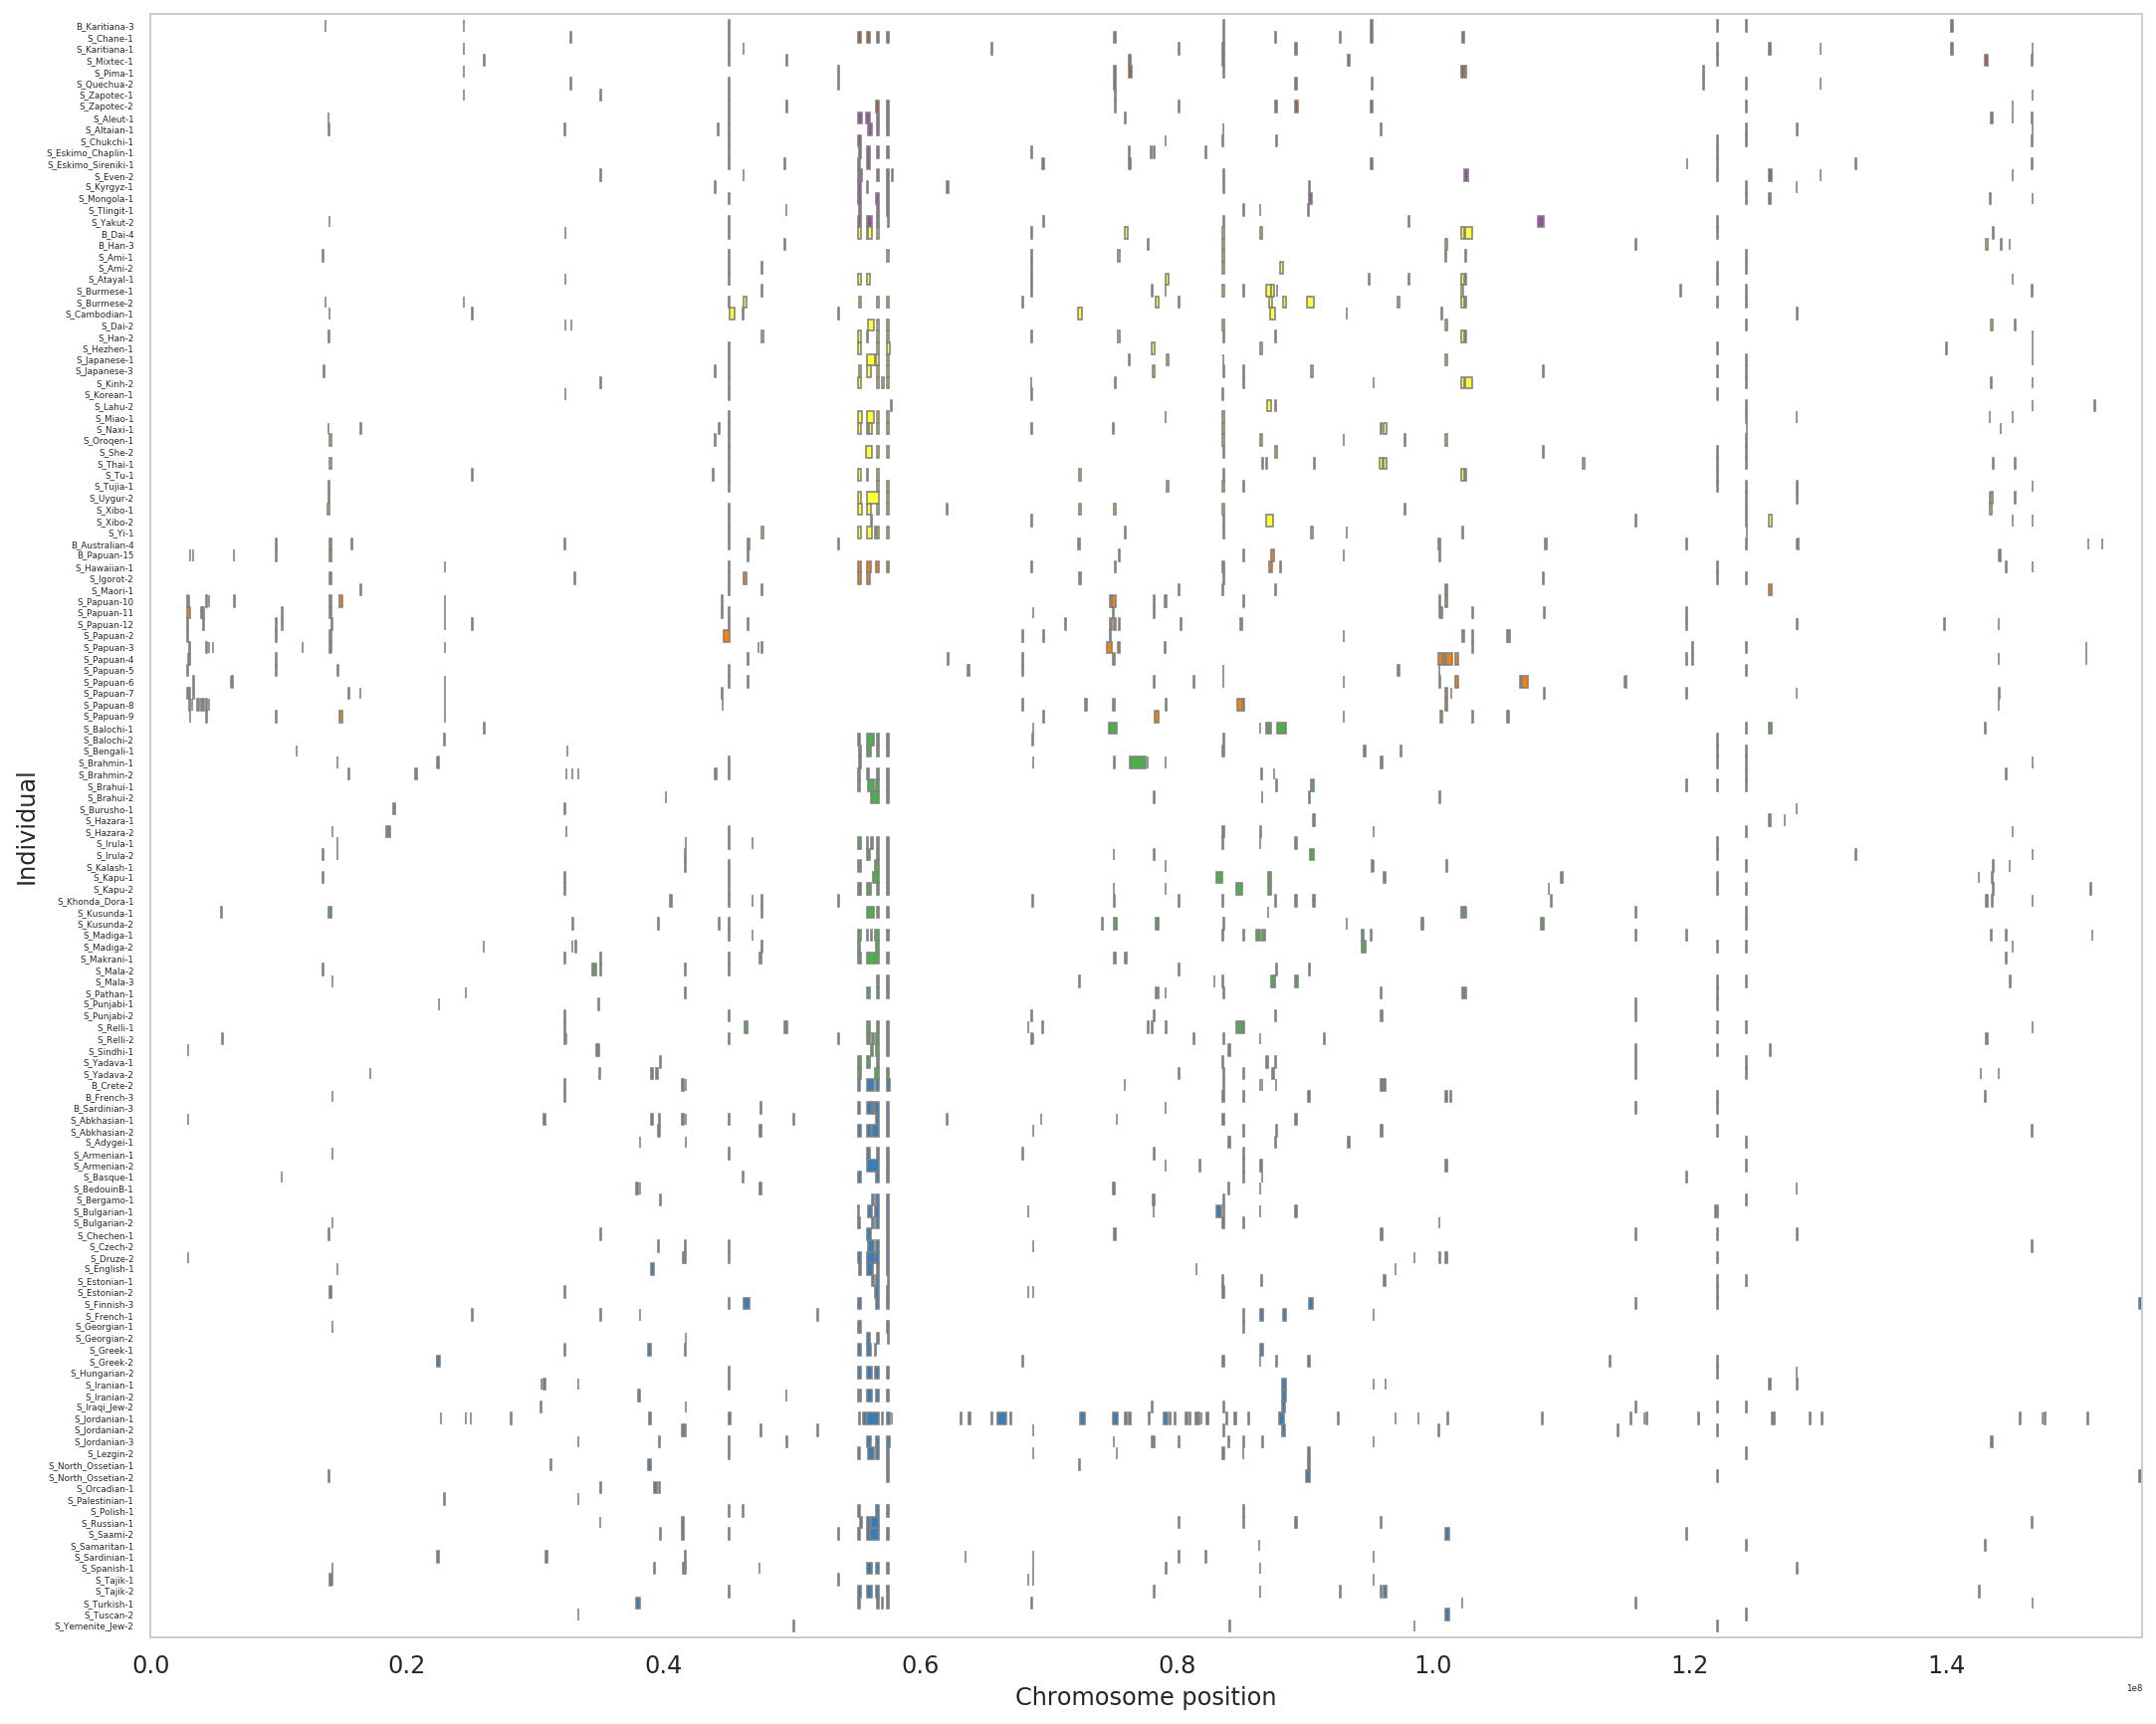

In [29]:
with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_individuals)])
        labs = pandas.Categorical(all_individuals,
                           categories=all_individuals,
                           ordered=True)
        plt.yticks(range(len(labs)), reversed(labs))

        for segm in plot_df.itertuples():            
            y = len(all_individuals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region], edgecolor='grey'))

#         for segm in callability_data.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_individuals), 
#                      facecolor='lightblue', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

#        ax.set_xlim(70e6, 90e6)
        
        plt.tight_layout()

## By individual in 100kb windows

### Analysis without repeats

In [30]:
@window(size=window_size, fill='hg19')
def stats(df):
    if len(df):
        return {'nr_admix_tracts': df.start.count(), 
                'tot_admix_len': sum(df.end-df.start),
                'archaic_snps': df.archaic_snps.sum(),
                'altai_snps': df.altai_snps.sum(),
                'denisova_snps': df.denisova_snps.sum(),
                'vindija_snps': df.vindija_snps.sum(),
                'mean_post_prob': numpy.average(df.MeanProb, weights=df.end-df.start),
                'admix_prop': sum(df.end-df.start) / window_size}
    else:
        return {'nr_admix_tracts': 0, 
                'tot_admix_len': 0, 
                'archaic_snps': 0, 
                'altai_snps': 0, 
                'denisova_snps': 0, 
                'vindija_snps': 0,
                'mean_post_prob': numpy.nan,
                'admix_prop': 0 }

df = (male_x_admix_segments
                 .loc[lambda df: df.chrom == 'X']
                 .groupby(['chrom', 'name'])
                 .apply(stats)
                 .reset_index(level=['chrom', 'name'])
                )

male_x_admix_windows = df.merge(admix_callability_windows, on=['chrom', 'start', 'end'], how='left')

male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'admix_prop'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'mean_post_prob'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'archaic_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'altai_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'denisova_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.bases_analyzed < min_called_admix, 'vindija_snps'] = numpy.nan

male_x_admix_windows.head()

,chrom,name,start,end,nr_admix_tracts,tot_admix_len,archaic_snps,altai_snps,denisova_snps,vindija_snps,mean_post_prob,admix_prop,level_1,bases_analyzed
0,X,B_Australian-4,0,100000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1337
1,X,B_Australian-4,100000,200000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,5045
2,X,B_Australian-4,200000,300000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2,9875
3,X,B_Australian-4,300000,400000,0,0,0.0,0.0,0.0,0.0,NaN,0.0,3,26649
4,X,B_Australian-4,400000,500000,0,0,0.0,0.0,0.0,0.0,NaN,0.0,4,22968


In [31]:
male_x_admix_windows.to_hdf(results_dir / 'male_x_admix_windows.hdf', 'df', format='table', mode='w')

### Analysis including repeats

In [32]:
@window(size=window_size, fill='hg19')
def stats(df):
    if len(df):
        return {'nr_admix_tracts': df.start.count(), 
                'tot_admix_len': sum(df.end-df.start),
                'mean_post_prob': numpy.average(df.MeanProb, weights=df.end-df.start),
                'admix_prop': sum(df.end-df.start) / window_size}
    else:
        return {'nr_admix_tracts': 0, 
                'tot_admix_len': 0, 
                'mean_post_prob': numpy.nan,
                'admix_prop': 0 }
    
df = (male_x_admix_segments_full
                 .loc[lambda df: df.chrom == 'X']
                 .groupby(['chrom', 'name'])
                 .apply(stats)
                 .reset_index(level=['chrom', 'name'])
                )

male_x_admix_windows_full = df.merge(admix_full_callability_windows, on=['chrom', 'start', 'end'], how='left')

male_x_admix_windows_full.loc[lambda df: df.bases_analyzed < min_called_admix, 'admix_prop'] = numpy.nan
male_x_admix_windows_full.loc[lambda df: df.bases_analyzed < min_called_admix, 'mean_post_prob'] = numpy.nan

male_x_admix_windows_full.head()

,chrom,name,start,end,nr_admix_tracts,tot_admix_len,mean_post_prob,admix_prop,level_1,bases_analyzed
0,X,B_Australian-4,0,100000,0,0,NaN,NaN,0,1602
1,X,B_Australian-4,100000,200000,0,0,NaN,NaN,1,6492
2,X,B_Australian-4,200000,300000,0,0,NaN,NaN,2,14598
3,X,B_Australian-4,300000,400000,0,0,NaN,0.0,3,37371
4,X,B_Australian-4,400000,500000,0,0,NaN,0.0,4,31532


In [33]:
male_x_admix_windows_full.to_hdf(results_dir / 'male_x_admix_windows_full.hdf', 'df', format='table', mode='w')

## Admixture propotion vs mean posterior probability of segments

For each window in each individual:

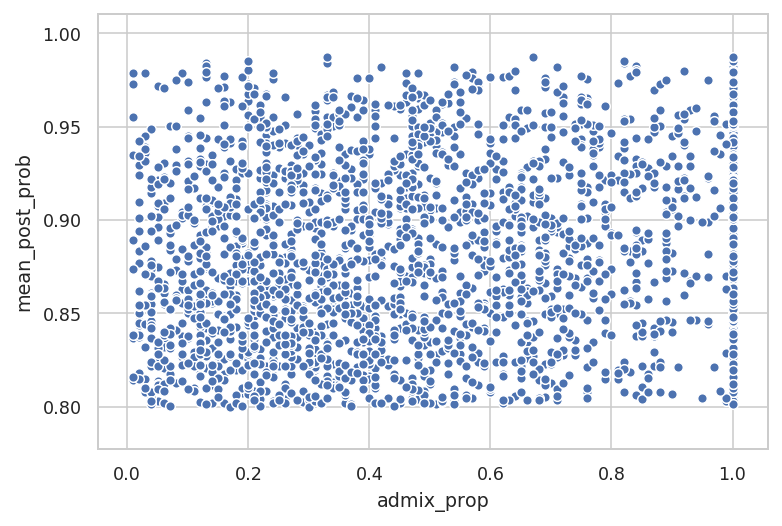

In [34]:
sns.scatterplot(male_x_admix_windows.admix_prop, male_x_admix_windows.mean_post_prob);

For mean admix proportion in 100kb windows across chromosome:

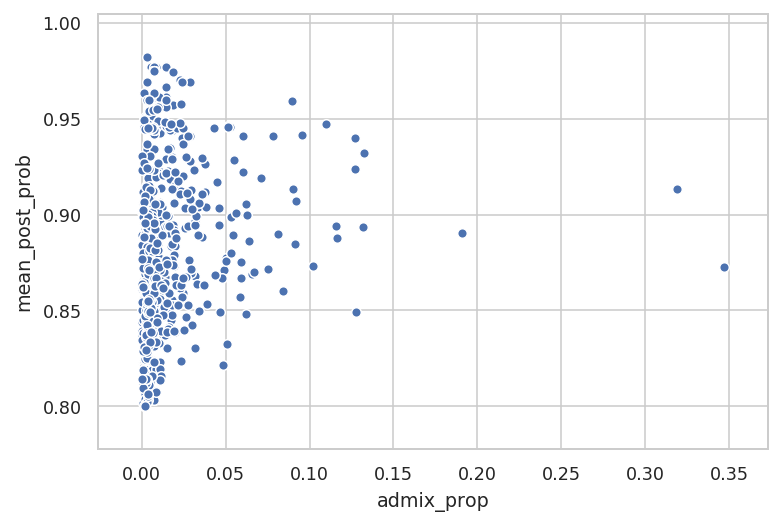

In [35]:
plot_df = male_x_admix_windows.groupby('start').mean()
sns.scatterplot(plot_df.admix_prop, plot_df.mean_post_prob);

## Admixture propotion vs number of archaic snps

For each window in each individual:

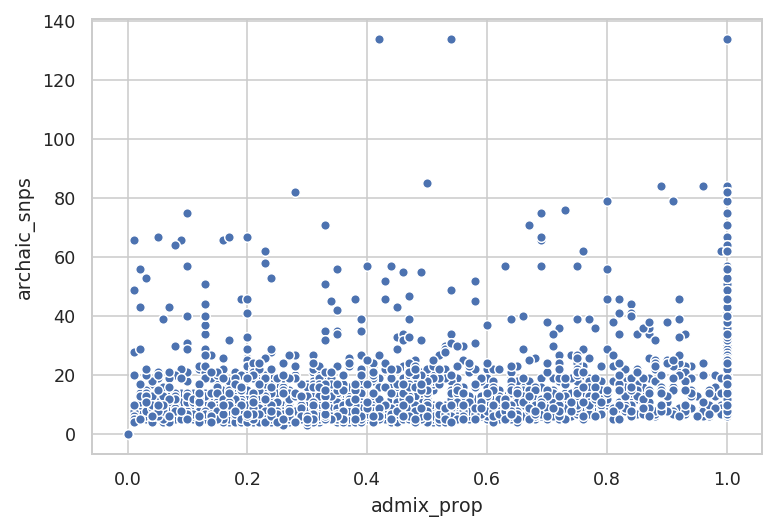

In [36]:
sns.scatterplot(male_x_admix_windows.admix_prop, male_x_admix_windows.archaic_snps);

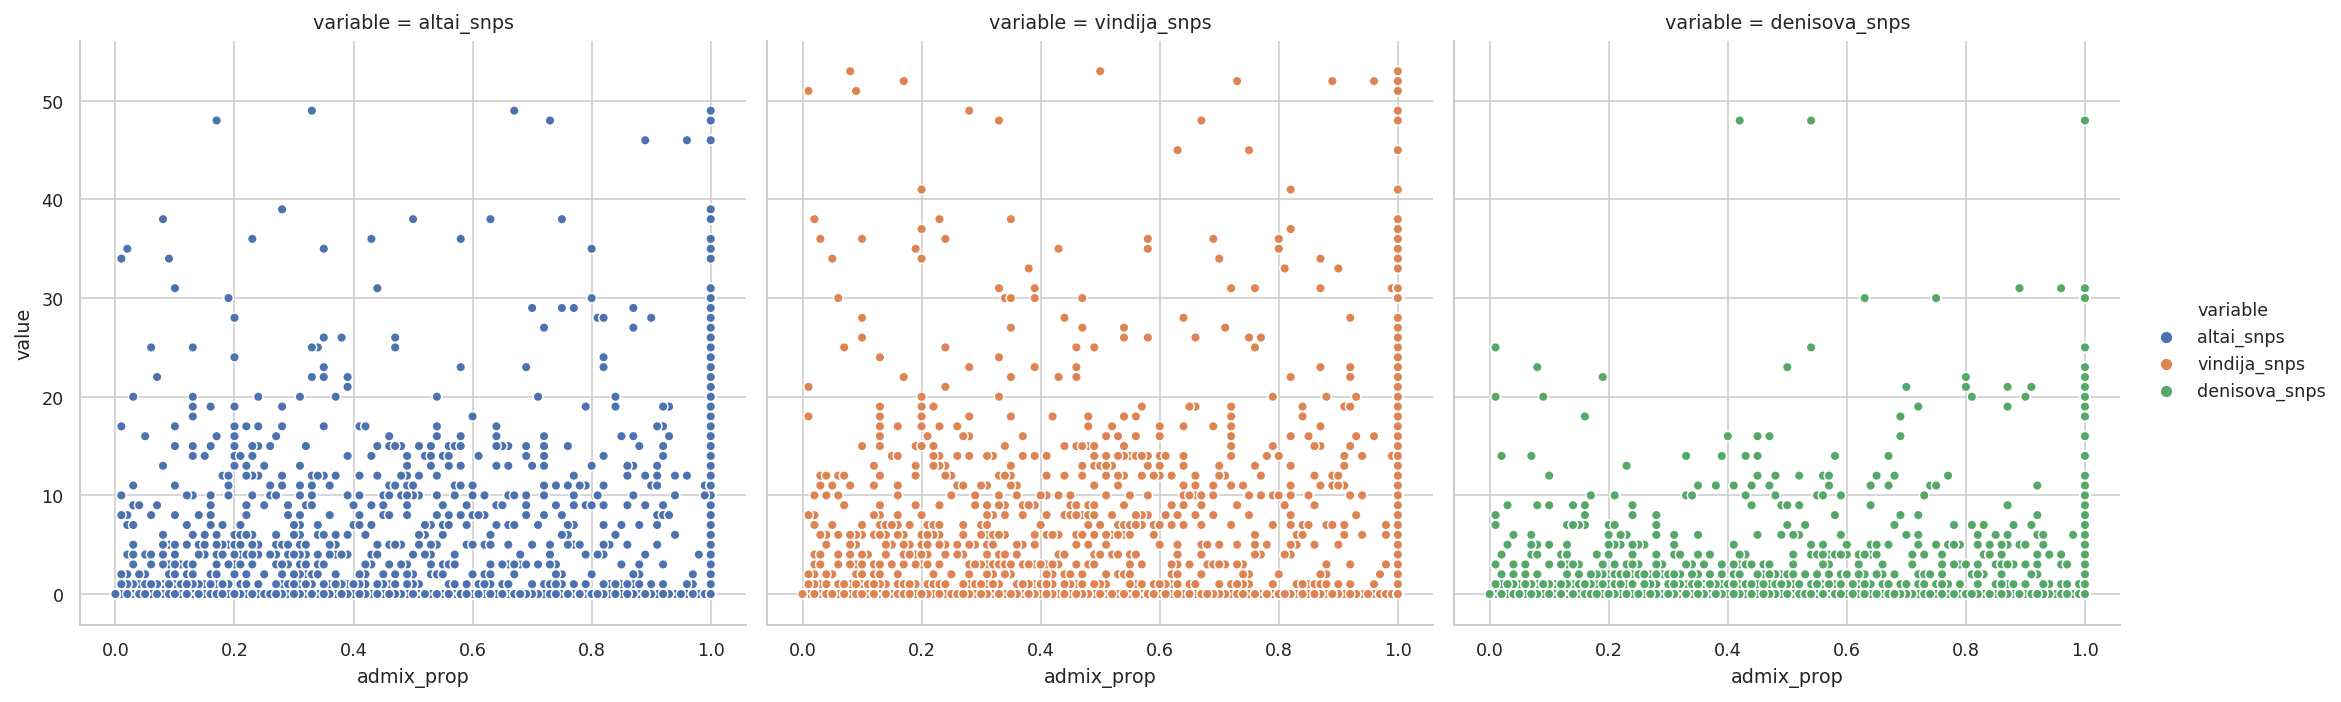

In [37]:
plot_df = male_x_admix_windows.melt(id_vars=['admix_prop'], value_vars=['altai_snps', 'vindija_snps', 'denisova_snps'])
sns.relplot(x="admix_prop", y="value", hue="variable", col="variable", data=plot_df);

For mean admix proportion in 100kb windows across chromosome:

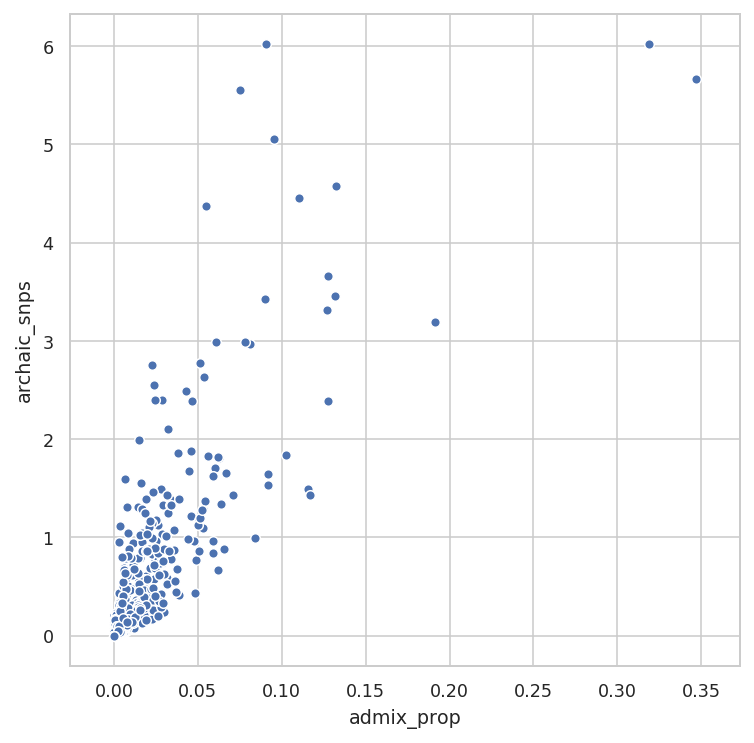

In [38]:
plot_df = male_x_admix_windows.groupby('start').mean()

plt.figure(figsize=(6, 6))
sns.scatterplot(plot_df.admix_prop, plot_df.archaic_snps);

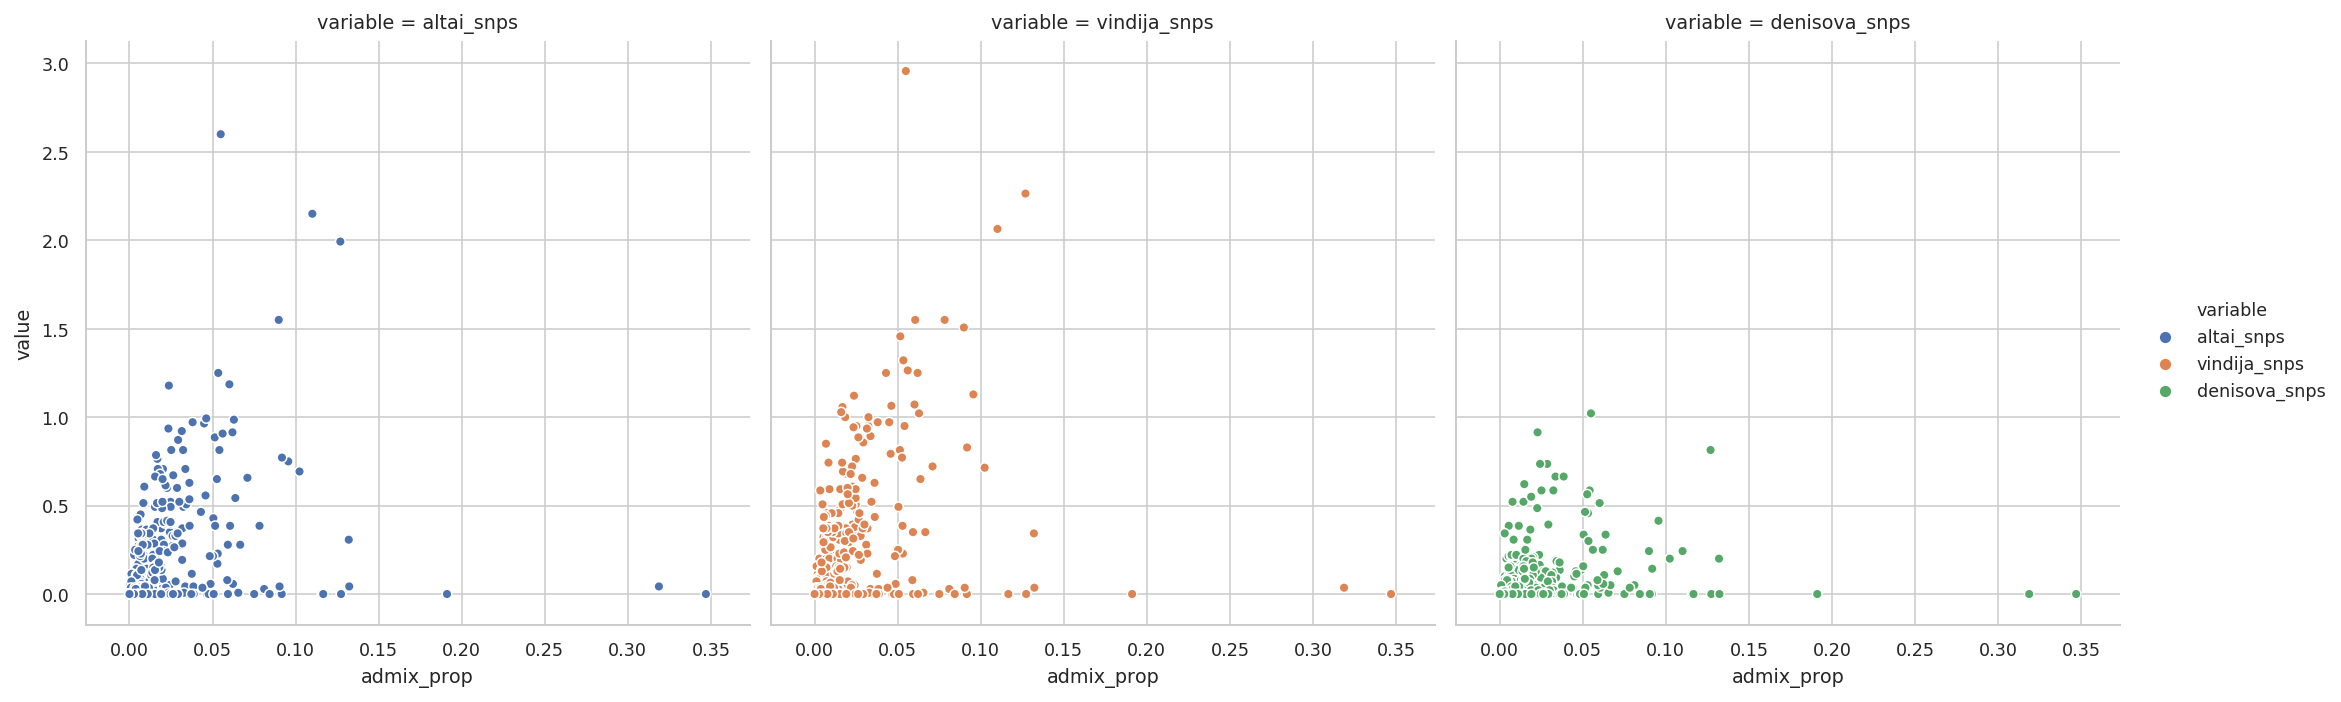

In [39]:
plot_df = plot_df.melt(id_vars=['admix_prop'], value_vars=['altai_snps', 'vindija_snps', 'denisova_snps'])
sns.relplot(x="admix_prop", y="value", hue="variable", col="variable", data=plot_df);

## Admixture proportion across chromosome

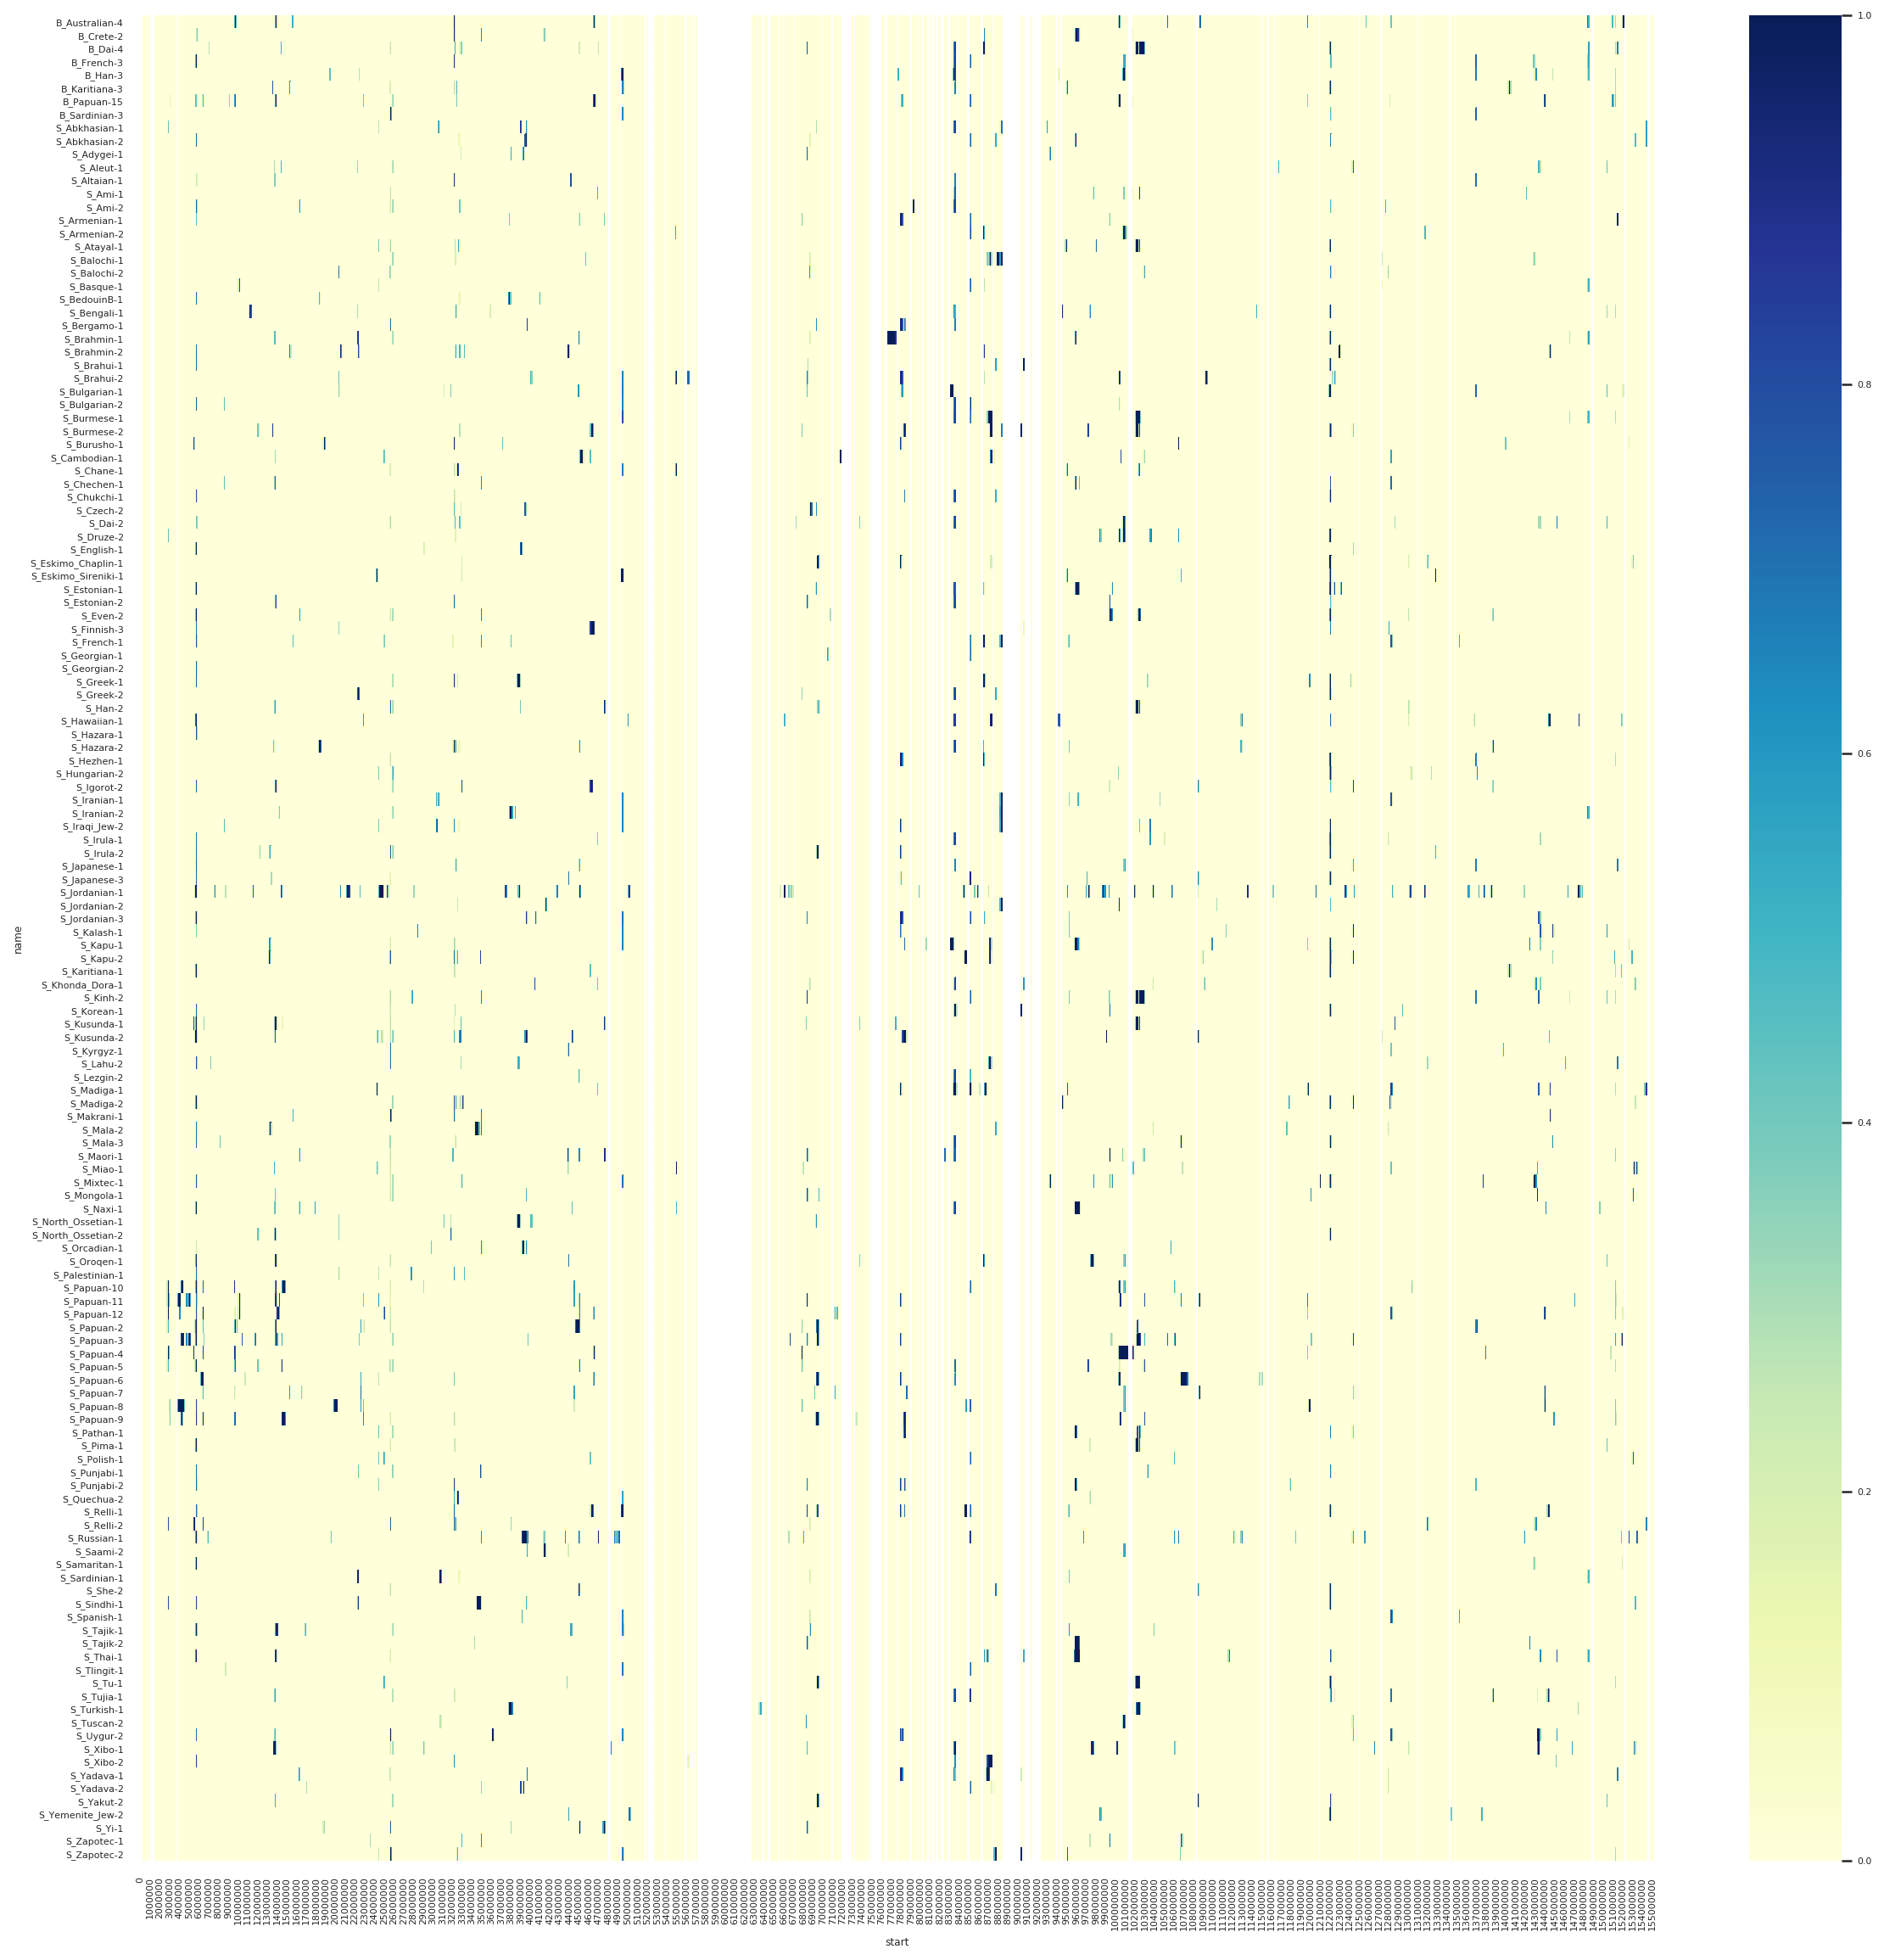

In [40]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(male_x_admix_windows.pivot('name', 'start', 'admix_prop'), cmap="YlGnBu")

Distribution of number of archaic SNPs in windows with such SNPs:

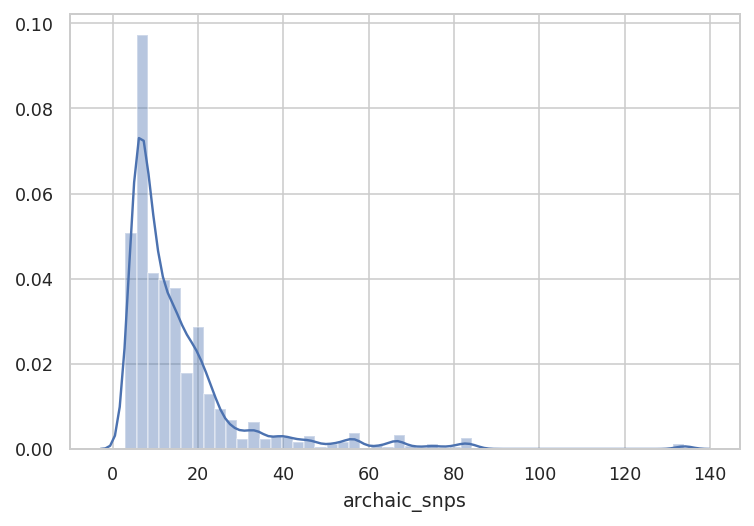

In [41]:
g = sns.distplot(male_x_admix_windows.loc[lambda df: numpy.bitwise_and(~numpy.isnan(df.archaic_snps),
                                                                       df.archaic_snps != 0)].archaic_snps)

1Mb means:

In [42]:
window_size = 1000000
# @window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0,
#                                'archaic_snps': 0, 'altai_snps': 0, 'denisova_snps': 0, 'vindija_snps': 0})
@window(size=window_size, fill='hg19')
def mb_means(df):
    return {'nr_admix_tracts': df.nr_admix_tracts.mean(), 
            'tot_admix_len': df.tot_admix_len.mean(), 
            'archaic_snps': df.archaic_snps.sum(),
            'altai_snps': df.altai_snps.sum(),
            'denisova_snps': df.denisova_snps.sum(),
            'vindija_snps': df.vindija_snps.sum(),
            'admix_prop': df.admix_prop.mean()}

cols = ['chrom', 'name']
male_x_admix_windows_1Mb = (male_x_admix_windows
                          .groupby(cols)
                          .apply(mb_means)
                          .reset_index(level=cols)
                          )

male_x_admix_windows_1Mb.to_hdf(results_dir / 'male_x_admix_windows_1Mb.hdf', 'df', format='table', mode='w')

In [43]:
male_x_admix_windows_1Mb.head()

,chrom,name,start,end,nr_admix_tracts,tot_admix_len,archaic_snps,altai_snps,denisova_snps,vindija_snps,admix_prop
0,X,B_Australian-4,0,1000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,X,B_Australian-4,1000000,2000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,X,B_Australian-4,2000000,3000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,X,B_Australian-4,3000000,4000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,X,B_Australian-4,4000000,5000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Amount of admixture

In [44]:
def get_region(df):
    regions = list()
    for name in df.name:
        if name in individuals:
            regions.append(individuals[name]['Region'])
        else:
            regions.append(numpy.nan)
    return regions
    
male_x_admix_windows.assign(region = get_region).groupby(['region']).mean()

,start,end,nr_admix_tracts,tot_admix_len,archaic_snps,altai_snps,denisova_snps,vindija_snps,mean_post_prob,admix_prop,level_1,bases_analyzed
region,,,,,,,,,,,,
America,77600000.0,77700000.0,0.010947,490.180296,0.154637,0.041431,0.012802,0.052621,0.885503,0.005840,776.0,34035.414681
CentralAsiaSiberia,77600000.0,77700000.0,0.009079,415.904701,0.110000,0.018145,0.004032,0.017823,0.875964,0.004812,776.0,34035.414681
EastAsia,77600000.0,77700000.0,0.013594,698.600081,0.243937,0.072849,0.016189,0.086768,0.885654,0.008292,776.0,34035.414681
Oceania,77600000.0,77700000.0,0.022416,1188.948809,0.528831,0.134778,0.102117,0.159778,0.890337,0.014374,776.0,34035.414681
SouthAsia,77600000.0,77700000.0,0.014062,709.448933,0.256530,0.083039,0.032908,0.104761,0.890378,0.008131,776.0,34035.414681
WestEurasia,77600000.0,77700000.0,0.010692,544.886242,0.174916,0.041885,0.013122,0.051310,0.883813,0.006363,776.0,34035.414681


## Archaic SNPs in windows along chromosome

For each window we need to know how many differences between male haplogypes are due to archiac snps. We want to be ale to filter them out to make sure it does not inflate estimated diffs in a way that makes unable to call sweeps in regions with admxiture.

Read all snp positions:

In [45]:
from collections import defaultdict

groups = male_x_admix_segments.groupby('name')

archaic_snps = defaultdict(set)
for indiv, group in groups:
    for tup in group.itertuples():
        one_based = [int(x) for x in tup.snps.split(',') if x]
        zero_based = [x-1 for x in one_based]
        archaic_snps[indiv].update(zero_based)

In [46]:
import pyfaidx

file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)

In [47]:
archaic_snps_by_indiv = None

male_indivs = list()
for indiv in male_x_admix_segments.name.unique():
    if individuals[indiv]['Genetic sex assignment'] == 'XY':
        male_indivs.append(indiv)

for indiv in male_indivs:    
    snps = archaic_snps[indiv]
    assert snps

#    indiv += '-A' ### Make table with indiv names without -A ......
    chrom = file_index[indiv + '-A']['X'][:].seq    
        
    bases = [chrom[pos] for pos in snps]
    df = pandas.DataFrame().from_records(zip(snps, bases), columns=['pos', 'base'])
    df[indiv] = True

    if archaic_snps_by_indiv is None:
        archaic_snps_by_indiv = df
    else:
        archaic_snps_by_indiv = archaic_snps_by_indiv.merge(df, on=['pos', 'base'], how='outer')
    
archaic_snps_by_indiv = archaic_snps_by_indiv.fillna(False)

In [48]:
archaic_snps_by_indiv.head()

,pos,base,S_Brahui-2,S_Finnish-3,S_Karitiana-1,S_Burusho-1,S_She-2,S_Armenian-2,S_Tu-1,S_Chane-1,...,S_North_Ossetian-1,S_Georgian-1,B_Sardinian-3,S_Han-2,S_Papuan-4,S_Yadava-1,S_Hazara-2,S_French-1,S_Greek-2,S_Iranian-1
0,49552901,G,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,56271366,C,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,55083017,C,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,54948372,G,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,40231463,A,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


Make sure there are at most one one ref and one alternative base for each position:

In [49]:
archaic_snps_by_indiv.loc[lambda df: df.base != 'N'].groupby(['pos'])['base'].count().unique()

array([1, 2])

Add all snps called in one individual to all indivisuals:

In [50]:
all_pos = archaic_snps_by_indiv.pos
all_bases = archaic_snps_by_indiv.base

archaic_snps_by_indiv.set_index(['pos', 'base'], inplace=True)

for indiv in male_indivs: 
    chrom = file_index[indiv + '-A']['X'][:].seq

    for pos, base in zip(all_pos, all_bases):
        if base != 'N' and chrom[pos] == base:
            archaic_snps_by_indiv.loc[(pos, base), indiv] = True

archaic_snps_by_indiv.reset_index(inplace=True)

Compute the number of archaic SNPs in windows:

In [51]:
def archaic_snp_counts_in_windows(binsize):

    chrom_size = chromosome_lengths['X']
    cuts = list(range(0, chrom_size+1, binsize))

    pair_list = list()
    for indiv_1 in male_indivs:
        for indiv_2 in male_indivs:
            if indiv_1 == indiv_2:
                continue

            snp_set1 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_1]].pos)
            snp_set2 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_2]].pos)
            
            archaic_het_sites = sorted(snp_set1.symmetric_difference(snp_set2))
            
            bin_starts = pandas.cut(archaic_het_sites, bins=cuts, labels=cuts[:-1], right=False)
            df = DataFrame({'indiv_1': indiv_1, 
                            'indiv_2': indiv_2, 
                            'start': bin_starts, 
                            'archaic_hets': archaic_het_sites})
            df = df.groupby(['indiv_1', 'indiv_2', 'start']).count().reset_index()
            pair_list.append(df)

    return pandas.concat(pair_list)

In [52]:
archaic_snp_counts = archaic_snp_counts_in_windows(100000)
archaic_snp_counts.to_hdf(results_dir / 'archaic_snp_counts.hdf', 'df', format='table', mode='w')
archaic_snp_counts.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,100000,NaN
2,S_Brahui-2,S_Finnish-3,200000,NaN
3,S_Brahui-2,S_Finnish-3,300000,NaN
4,S_Brahui-2,S_Finnish-3,400000,NaN


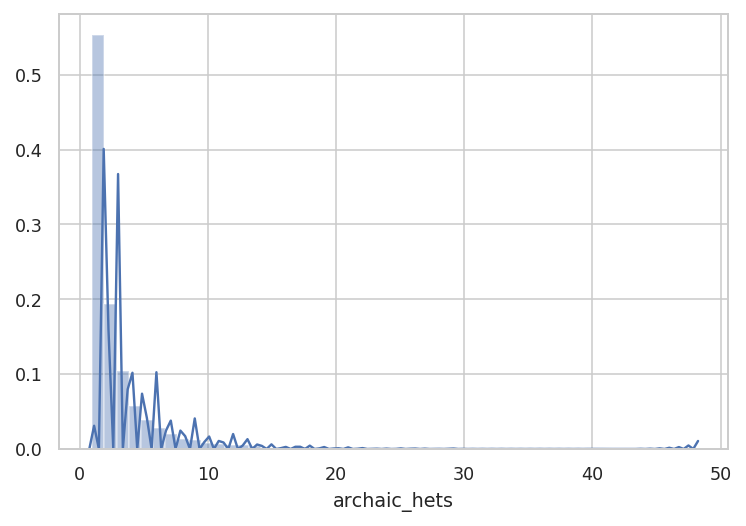

In [53]:
g = sns.distplot(archaic_snp_counts.archaic_hets.loc[archaic_snp_counts.archaic_hets > 0])

In [54]:
archaic_snp_counts_1Mb = archaic_snp_counts_in_windows(1000000)
archaic_snp_counts_1Mb.to_hdf(results_dir / 'archaic_snp_counts_1Mb.hdf', 'df', format='table', mode='w')
archaic_snp_counts_1Mb.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,1000000,NaN
2,S_Brahui-2,S_Finnish-3,2000000,NaN
3,S_Brahui-2,S_Finnish-3,3000000,NaN
4,S_Brahui-2,S_Finnish-3,4000000,1.0


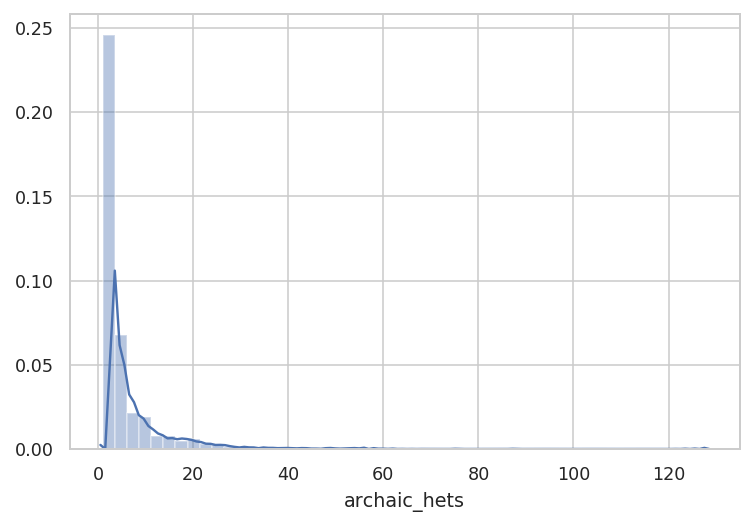

In [55]:
g = sns.distplot(archaic_snp_counts_1Mb.archaic_hets.loc[archaic_snp_counts_1Mb.archaic_hets > 0])